###### CSCE 320 :: Principles of Data Science ::Texas A&M University :: Fall 2020


# Group Project: Analysis of Election Data over Time for the purpose of finding the Optimal set of Training Data



Members: Matthew Spence, Adrian Shi, Marcel Theo, Michael Chaco

## Major Question:
What chronological subset of training data produces the most accurate election forecasting models?

## Purpose:
The outcomes of presidential elections shape U.S. government policy, which affects the lives of every American. We hope to determine if a predictive model generated from U.S. polling data is more or less accurate than historical data. 
Potential beneficiaries of this project are U.S. allies or businesses looking to predict the types of policies that will be implemented (which can affect their business)

## Method:
We intend to train multiple machine learning models of the same type on different subsets of training data. Each model will be trained on a chronologically continuous subset of election related data ending in 2016, and starting in each election year after 1936, ie 1936-2016, 1940-2016, 1944-2016...2012-2016. We will then compare the predictions of the various models to the actual outcome of the 2020 election, and see which is the most accurate. 
 
### Getting started: 
First we need to gather our data and clean it. Our datasets are as follows, and are divided up into pre-election data and post-election data. 
post-election: 
Popular Vote in U.S. Elections (Statista)
Historical Electoral Vote (Data Galore)
Binary Election outcome (Manually input)

pr-election data: 
Historic head to head polling data (Gallup)
Incumbent approval ratings (Gallup)
Past electoral votes by state (Electoral-Vote.com)
Government Approval Ratings (Pew Research)
Unemployment rate (Trading Economics)
GDP growth by year (Trading Economics)
Incumbency (Manually input)
Previous President's Political Party (Manually input)


In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

# insert imports and data cleaning here
elections = pd.read_csv("CSV/elections-1900-to-2012.csv", encoding="utf-8") 
electoralVotes = pd.read_csv("CSV/electoral_votes.csv", encoding="utf-8") 
approvalRatings = pd.read_csv("CSV/incumbency_approval_ratings.csv", encoding="utf-8") 
#polling = pd.read_csv("CSV/polling.csv", encoding="utf-8") 
popularVotes = pd.read_csv("CSV/popular_votes.csv", encoding="utf-8") 
trustRating = pd.read_csv("CSV/trust_rating.csv", encoding="utf-8")

CleanedData = pd.read_csv("CSV/cleaned_data.csv", encoding="utf-8")

#change percentages in CleanedData to decimal
CleanedData['poll_d'] = CleanedData['poll_d'].str.rstrip('%').astype('float') / 100.0
CleanedData['poll_r'] = CleanedData['poll_r'].str.rstrip('%').astype('float') / 100.0
CleanedData['gdp_percent'] = CleanedData['gdp_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['electoral_r_percent'] = CleanedData['electoral_r_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['electoral_d_percent'] = CleanedData['electoral_d_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['popular_d_percent'] = CleanedData['popular_d_percent'].str.rstrip('%').astype('float') / 100.0
CleanedData['popular_r_percent'] = CleanedData['popular_r_percent'].str.rstrip('%').astype('float') / 100.0

CleanedData.head()

,year,electoral_d,electoral_r,total_electoral,electoral_d_percent,electoral_r_percent,popular_d,popular_r,popular_d_percent,popular_r_percent,poll_d,poll_r,incumbent,incumbent_won,incumbent_approval,trust,gdp_percent,current_party,party_won,year.1
0,1900,155,292,447,0.3468,0.6532,6370932,7228864,0.4550,0.5170,NaN,NaN,0,0,NaN,NaN,NaN,1,1,1900
1,1904,140,336,476,0.2941,0.7059,5083880,7228864,0.3760,0.5640,NaN,NaN,1,1,NaN,NaN,NaN,1,1,1904
2,1908,162,321,483,0.3354,0.6646,6408979,7678335,0.4300,0.5160,NaN,NaN,0,-1,NaN,NaN,NaN,1,1,1908
3,1912,435,8,531,0.8192,0.0151,6296284,3486242,0.4180,0.2320,NaN,NaN,1,0,NaN,NaN,NaN,1,0,1912
4,1916,277,254,531,0.5217,0.4783,9126868,8548728,0.5216,0.4783,NaN,NaN,1,1,NaN,NaN,NaN,0,0,1916


### A key decision in this project will be what machine learning model we use. We intend to use a model from the sklearn library. The goal of this project is not to test the accuracy of a given model per se, but rather to find the best set of training data. As such we considered a few relatively simple models:
Linear Regression<br>
Ridge Regression<br>
Lasso Regression<br>

### After reviewing the current techniques used in professional election forecasting, we decided that a linear regression would serve our purposes well. This model is already familiar to us through our class work, and is easy to work with. This will enable us to spend less time worrying about optimizing our model and more time testing different subsets of data. 



In [2]:
# get the data into a dataframe
data = pd.DataFrame(CleanedData)
data.head()

,year,electoral_d,electoral_r,total_electoral,electoral_d_percent,electoral_r_percent,popular_d,popular_r,popular_d_percent,popular_r_percent,poll_d,poll_r,incumbent,incumbent_won,incumbent_approval,trust,gdp_percent,current_party,party_won,year.1
0,1900,155,292,447,0.3468,0.6532,6370932,7228864,0.4550,0.5170,NaN,NaN,0,0,NaN,NaN,NaN,1,1,1900
1,1904,140,336,476,0.2941,0.7059,5083880,7228864,0.3760,0.5640,NaN,NaN,1,1,NaN,NaN,NaN,1,1,1904
2,1908,162,321,483,0.3354,0.6646,6408979,7678335,0.4300,0.5160,NaN,NaN,0,-1,NaN,NaN,NaN,1,1,1908
3,1912,435,8,531,0.8192,0.0151,6296284,3486242,0.4180,0.2320,NaN,NaN,1,0,NaN,NaN,NaN,1,0,1912
4,1916,277,254,531,0.5217,0.4783,9126868,8548728,0.5216,0.4783,NaN,NaN,1,1,NaN,NaN,NaN,0,0,1916


### Once we have all of our raw data in an easily usable format, we need to divide the data into testable subsets. We want to see what chronologically continuous subset of training data provides the most accurate predictions for the 2020 election. That is, we want to train a model for every possible subset of data that includes every election after a given cutoff year, where the cutoff year will be set at some past election eg 1960-2016, 1964-2016, 1968-2016 ... 2012-2016, only 2016. This means that for n elections for which we have viable data, we will have n different subsets of data to test. 

In [3]:
# dataInRange returns the cleaned data in a given range of years.

def dataInRange(df, startYear, endYear):
    newDf = df[df['year'].between(startYear, endYear)]
    return newDf

### Before we train our models, we need the best available data on the 2020 election to get the various model's predictions.  

In [4]:
# import 2020 data
thisYear = data[data['year'].between(2020, 2020)]

### Now that we have our training data and our model, we need to decide what technique to use to train the model. We also need to decide how to define and measure the "accuracy" of a given model. There are many metrics associated with elections, including binary outcome, popular vote, electoral college vote, states won, etc. We decided to start simple, by predicting the binary outcome, and naively training the model on the test data. We will also need a way to visualize the results, which we have provided via the following function

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import PIL



def display_grid(imgs, grid_shape, scale=0.1, axes_pad=0.07):

    # Grid must be 2D:
    assert len(grid_shape) == 2

    # Make sure all images can fit in grid:
    assert grid_shape[0]*grid_shape[1] >= len(imgs)

    grid = ImageGrid(plt.gcf(), 111, grid_shape, axes_pad=axes_pad)
    for i, data in enumerate(imgs):

        # Scale image:
        im = data
        thumb_shape = [im.size[0]*scale, im.size[1]*scale]
        im.thumbnail(thumb_shape, PIL.Image.ANTIALIAS)
        data_thumb = np.array(im)
        grid[i].imshow(data_thumb)

        # Turn off axes:
        grid[i].axes.get_xaxis().set_visible(False)
        grid[i].axes.get_yaxis().set_visible(False)
        grid[i].axis("off")
        grid[i].set_title(1936+4*i)

### In the first run of our predictions using linear regression, we tried to predict the binary outcome of 2020’s election using zero as a democrat win and 1 as a republican win. This was, to put it bluntly, pretty stupid. The result we received from each model were decimal values ranging from a negative number to three, concentrating between zeros and one. Linear regressions are not appropriate for binary predictions, as they require the outcome for a given input to be continous. A more appropriate model for predicting binary outcomes would be a logistic regression. This is a very simple change, so we have provided the results below.

Binary outcome predictions: 
[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]


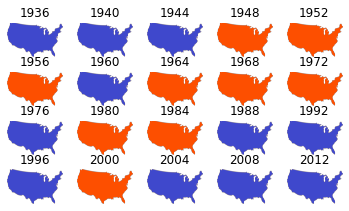

In [6]:
# train the models to predict the binary outcome.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import numpy as np

FIRST_YEAR = 1936
LAST_YEAR = 2016

predictions_binary = []

#
# get binary outcome predictions
#

# Iterate over every possible range of years
for i in range(FIRST_YEAR,LAST_YEAR, 4): 
        # train model for each of these subsets..
        subset = dataInRange(data, i, LAST_YEAR)
        x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y = subset['party_won'] # binary outcome data from this subset of years
        model = LogisticRegression()
        model.fit(x,y)
        
        ### Next, predict y from the 2020 data
        x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y_new = model.predict(x_new)
        predictions_binary.append(y_new[0]) # for some reason y_new creates an array of one element, so use the first (and only) element

print("Binary outcome predictions: ")
print(predictions_binary)

images = []
redMap = PIL.Image.open('Images/RedMap.png')
blueMap= PIL.Image.open('Images/BlueMap.png')

for res in predictions_binary:
    images.append(blueMap.copy() if res==0 else redMap.copy())
    
display_grid(images, [4, 5], scale=0.5, axes_pad=0.2)


### These results are interesting, and worth analyzing, but there is a major problem with this approach. We want to gauge which subset of training data produces the optimal results, but we have no way of differentiating between two models that predicted the same binary outcome. No matter the actual result on Nov 3rd, almost have our models will be correct and we will have no way to distinguish which was "most" correct. We need a continuous, or at least much more varied, output. We decided from here that the electoral college vote would be the best measure. 

### There is a problem with this too, though. Electoral college votes are state level outputs based on state level inputs. We have only national data, and were unable to find reliable state level data going back any significant length of time. As such, we instead decided to predict the popular vote percentage for each major party candidate. This is an imperfect metric, since as we saw in 2016 it is not perfectly predictive of which candidate will win the election, but it is a continuous output that strongly correlates with the binary outcome of an election. 

In [7]:

predictions_r = []
predictions_d = []
predictions_r_total = []
predictions_d_total = []

#
# get popular vote percentage predictions for republicans
#

# Iterate over every possible range of years
for i in range(FIRST_YEAR,LAST_YEAR, 4): 
        # train model for each of these subsets..
        subset = dataInRange(data, i, LAST_YEAR)
        x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y = subset['popular_d_percent'] # binary outcome data from this subset of years
        model = LinearRegression()
        model.fit(x,y)
        
        ### Next, predict y from the 2020 data
        x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y_new = model.predict(x_new)
        predictions_d.append(y_new[0]) # for some reason y_new creates an array of one element, so use the first (and only) element

#        
# get popular vote percentage predictions for democrats
#

for i in range(FIRST_YEAR,LAST_YEAR, 4): 
        # train model for each of these subsets..
        subset = dataInRange(data, i, LAST_YEAR)
        x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
        y = subset['popular_r_percent'] # binary outcome data from this subset of years
        model = LinearRegression()
        model.fit(x,y)
        
        ### Next, predict y from the 2020 data
        x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval','current_party']]
        y_new = model.predict(x_new)
        predictions_r.append(y_new[0]) # for some reason y_new creates an array of one element, so use the first (and only) element



print("Popular vote predictions for republicans: ")
print(predictions_r)

print("Popular vote predictions for democrats: ")
print(predictions_d)


Popular vote predictions for republicans: 
[0.47268184870155006, 0.47120422698377534, 0.4694270577594551, 0.4668595068129433, 0.46739969915277807, 0.46797224261603254, 0.46814152924196806, 0.4667355483890437, 0.46633175211973144, 0.464353875778579, 0.46122121508699254, 0.4647958798762699, 0.44221612021381684, 0.433232936682836, 0.43241753311813336, 0.4470291627469427, 0.49180452829676913, 0.4979788127423165, 0.46889046790612715, 0.47169950930760635]
Popular vote predictions for democrats: 
[0.45581625273795845, 0.456769949352109, 0.4582388864504665, 0.4608553706440522, 0.4604283685354826, 0.45710551996643195, 0.4576301886202572, 0.4579750009254904, 0.4582525354888144, 0.46212662590487774, 0.46549910121734, 0.45547883849766146, 0.4815842467192919, 0.48581938345580405, 0.4853045495853995, 0.46980357478833484, 0.45564510580170986, 0.500790490901866, 0.5568628270707695, 0.5027904291984276]


### We should now have our predictions, time to visualize the results

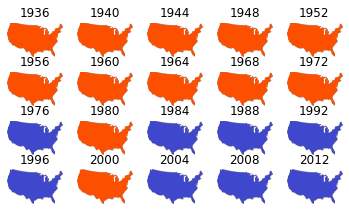

In [8]:
images = []
for res in zip(predictions_r, predictions_d):
    images.append(blueMap.copy() if res[0] < res[1] else redMap.copy())
    
display_grid(images, [4, 5], scale=0.5, axes_pad=0.2)

In [9]:
# use the same techniques as before the predict the popular vote margin

[1.6865595963591606, 1.4434277631666326, 1.1188171308988581, 0.6004136168891117, 0.697133061729549, 1.086672264960059, 1.0511340621710885, 0.8760547463553259, 0.8079216630917041, 0.22272498737012647, -0.42778861303474636, 0.9317041378608448, -3.9368126505475054, -5.258644677296803, -5.288701646726612, -2.2774412041392136, 3.6159422495059266, -0.28116781595495244, -8.797235916464235, -3.1090919890821302]
-3.400000000000003


[]

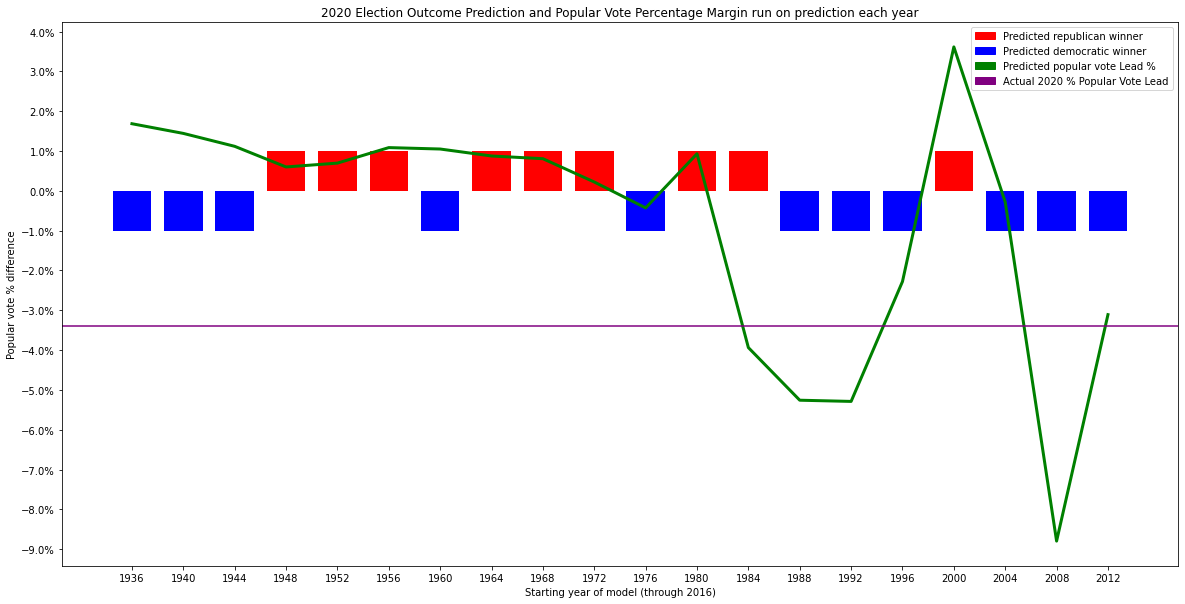

In [10]:
# Overlay the popular vote percentage difference over the binary predictions

from matplotlib.pyplot import step, show
import matplotlib.ticker as mtick


percentage_difference = []
for res in zip(predictions_r, predictions_d):
    percentage_difference.append((res[0] - res[1])*100)
    
#print(predictions_r)
#print(predictions_d)
print(percentage_difference)
tt_percentage_difference = (thisYear['popular_r_percent'].iloc[-1] - thisYear['popular_d_percent'].iloc[-1])*100
print(tt_percentage_difference)
x = np.arange(FIRST_YEAR, LAST_YEAR, 4, dtype=int) #years from 1936 to 2012

republican = [1 if p > 0 else 0 for p in predictions_binary] 
democrat = [-1 if p < 1 else 0 for p in predictions_binary]

# 1 is republican, -1 is democrat
colors = {'Predicted republican winner':'red', 'Predicted democratic winner':'blue', 'Predicted popular vote Lead %':'green', 'Actual 2020 % Popular Vote Lead':'purple'}   
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.bar(x, republican, width=3, color=colors['Predicted republican winner'])
ax.bar(x, democrat, width=3, color=colors['Predicted democratic winner'])
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.xticks(np.arange(min(x), max(x)+1, 4))
plt.yticks(np.arange(-10, 5, step=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Starting year of model (through 2016)')
plt.ylabel('Popular vote % difference')
plt.title('2020 Election Outcome Prediction and Popular Vote Percentage Margin run on prediction each year')
line, = plt.plot(x, percentage_difference, linewidth=3.0, color='g')
line.set_label('Label via method')
plt.axhline(y=tt_percentage_difference, color='purple')
plt.plot()

#notes:
# Scale down the 1 to negative 1, (scale up to 2 but remove the 2), scale up the line so differences are more clear

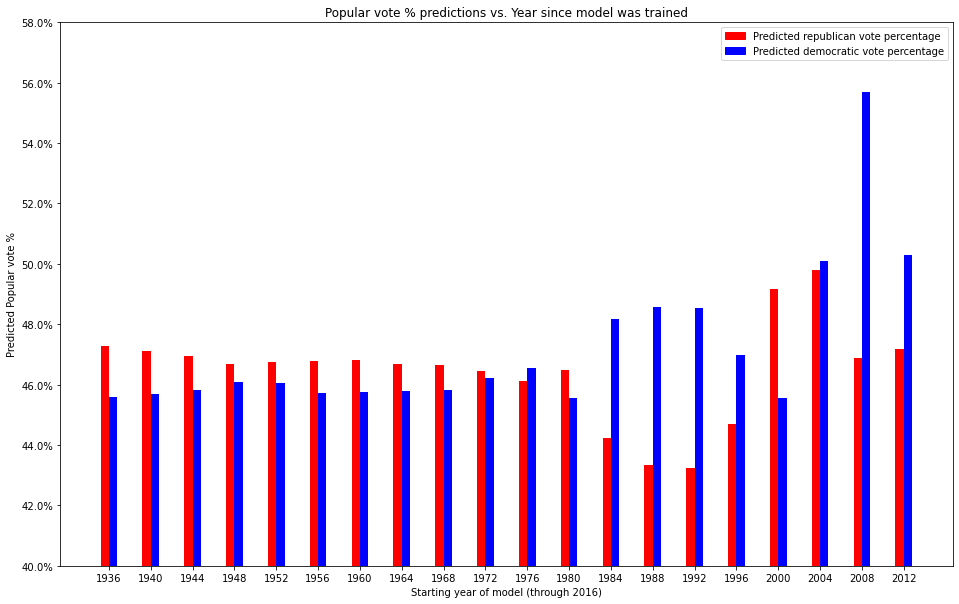

In [11]:
#### Compare the popular vote predictions

from matplotlib.pyplot import step, show

x = np.arange(FIRST_YEAR, LAST_YEAR, 4, dtype=int) #years from 1936 to 2012

fig = plt.figure(figsize=(16,10))
ax = plt.subplot(111)
width = 0.8
ax.bar(x - width/2, predictions_r, width, label='Republican', color='r')
ax.bar(x + width/2, predictions_d, width, label='Democrat',   color='b')
colors = {'Predicted republican vote percentage':'red', 'Predicted democratic vote percentage':'blue'}   
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.xticks(np.arange(min(x), max(x) + 1, 4))
ax.set(ylim=[0.4, 0.58])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('Starting year of model (through 2016)')
plt.ylabel('Predicted Popular vote %')
plt.title('Popular vote % predictions vs. Year since model was trained')

plt.show()
# notes:

### Now that the 2020 election is over, we can compare the predictions of our models to the actual results. 

In [12]:
# insert visualization here, comparing actual vs predicted results over time
# Recommend a bar chart showing the absolute difference between the actual vs predicted popular vote,
# with each bar colored based on whether it also predicted the binary outcome correctly. 

## Results: 

### There are some notable results here. We initially hypothesized that, as we approached more recent starting elections and the size of our training data got smaller, there would be an increase in the variation of the predictions. The charts above bare this out, there is indeed a large increase in the volatility of predictions as we get past ~1980. Whats especially noteworthy, however, is that the most stable predictions, which were made using the largest set of training data, are not especially accurate. They wrongly predict the popular vote margin, and are often wrong about the binary outcome as well. We somewhat anticipated this result: we only have 21 elections in our largest possible dataset, which probably isn't enough to train a robust model. 

### Interestingly, the most accurate model is the one trained only on the 2012 and 2016 election. This is worth exploring further. Let's see what happens if we test every past election with a model trained on the two previous elections. 

In [13]:
predictions_r = []
predictions_d
FIRST_YEAR = 1944
LAST_YEAR = 2016

for i in range(FIRST_YEAR,LAST_YEAR, 4): 
    thisYear = data[data['year'].between(i, i)]
    # train model for each of these subsets..
    subset = dataInRange(data, i-8, i)
    x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
    y = subset['popular_r_percent'] # binary outcome data from this subset of years
    model = LinearRegression()
    model.fit(x,y)
    
    ### Next, predict y from the test year data
    x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval','current_party']]
    y_new = model.predict(x_new)
    predictions_r.append(y_new[0])
    
    y = subset['popular_d_percent'] # binary outcome data from this subset of years
    model.fit(x,y)
    
    y_new = model.predict(x_new)
    predictions_d.append(y_new[0])

print(predictions_r)
print(predictions_d)

[0.45799999999999996, 0.45, 0.549, 0.574, 0.495, 0.385, 0.43400000000000005, 0.607, 0.48, 0.5039999999999999, 0.588, 0.534, 0.37400000000000005, 0.40700000000000003, 0.479, 0.5069999999999999, 0.457, 0.472]
[0.45581625273795845, 0.456769949352109, 0.4582388864504665, 0.4608553706440522, 0.4604283685354826, 0.45710551996643195, 0.4576301886202572, 0.4579750009254904, 0.4582525354888144, 0.46212662590487774, 0.46549910121734, 0.45547883849766146, 0.4815842467192919, 0.48581938345580405, 0.4853045495853995, 0.46980357478833484, 0.45564510580170986, 0.500790490901866, 0.5568628270707695, 0.5027904291984276, 0.5329999999999999, 0.494, 0.44399999999999995, 0.41999999999999993, 0.49700000000000005, 0.6109999999999999, 0.42700000000000005, 0.37500000000000006, 0.5, 0.41, 0.406, 0.4570000000000001, 0.42999999999999994, 0.492, 0.48400000000000004, 0.483, 0.529, 0.511]


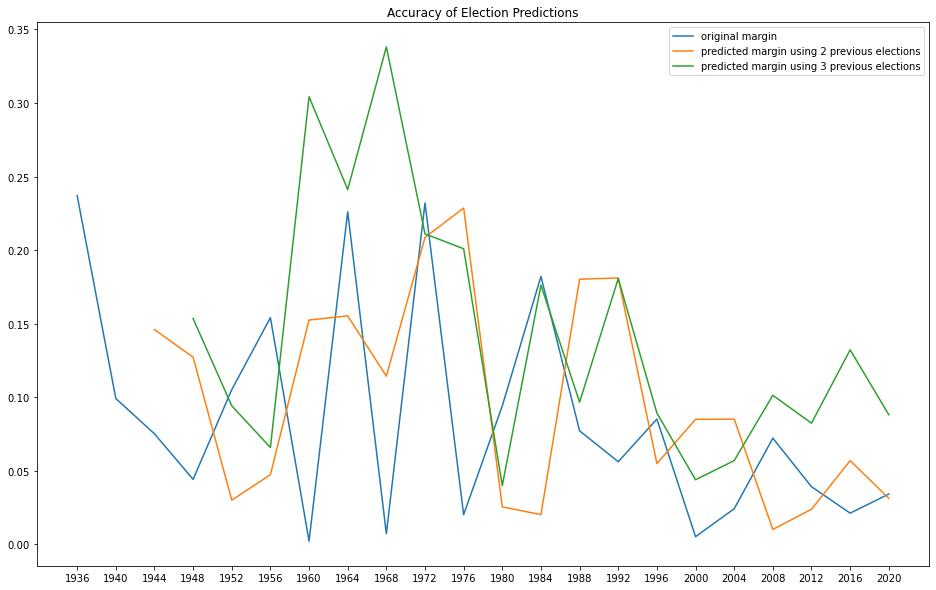

In [17]:
def num_prev_elec(num_prev, original = True, start_year = 1936, end_year = 2020):
    """
    num_prev is a list identifying what models to show ... please don't put a values less than 2
    original will show the original data
    end_year is inclusive'
    returns data just for debugguing
    """
    data_dict = {}
    
    # add original data if needed
    if (original):
        margin = []
        data_range = dataInRange(data, start_year, end_year + 4)
        r_percent = data_range['popular_r_percent'].tolist()
        d_percent = data_range['popular_d_percent'].tolist()
        
        for r, d in zip(r_percent, d_percent):
            margin.append(abs(r-d))
        
        data_dict['original margin'] = [list(range(start_year, end_year + 4, 4)), margin]


    # go through how many previous years wanted
    for n_prev in num_prev:
        # get the absolute margin predictions
        FIRST_YEAR = start_year + (4 * n_prev)
        LAST_YEAR = end_year + 4
        margin = []
        dates = []
        for i in range(FIRST_YEAR,LAST_YEAR, 4):
            dates.append(i)
            predictions_r = []
            predictions_d = [] 
            
            thisYear = data[data['year'].between(i, i)]
            
            # train model for each of these subsets..
            subset = dataInRange(data, i - (4 * n_prev), i - 4) # --------------- -4 is because not including this year
            x = subset[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval', 'current_party']]
            y = subset['popular_r_percent'] # binary outcome data from this subset of years
            model = LinearRegression()
            model.fit(x,y)
            
            ### Next, predict y from the test year data
            x_new = thisYear[['poll_d', 'poll_r', 'incumbent', 'incumbent_approval','current_party']]
            y_new = model.predict(x_new)
            predictions_r.append(y_new[0])
            
            y = subset['popular_d_percent'] # binary outcome data from this subset of years
            model.fit(x,y)
            
            y_new = model.predict(x_new)
            predictions_d.append(y_new[0])

            # get the absolute margin
           
            for r, d in zip(predictions_r, predictions_d):
                margin.append(abs(r-d))
            
        data_dict['predicted margin using {} previous elections'.format(n_prev)] = [dates, margin]
    
    # graph the data
    fig = plt.figure(figsize=(16,10))
    for d in data_dict:
        x = data_dict[d][0]
        y = data_dict[d][1]
        plt.plot(x, y, label = d)
    
    plt.title('Accuracy of Election Predictions')
    plt.xticks(list(range(start_year, end_year + 4, 4)))
    plt.legend()
    plt.show()
    
    return data_dict


x = num_prev_elec([2 , 3])